<a href="https://colab.research.google.com/github/didi-a-p/Vacinacao_Febre_Amarela/blob/main/Analise_da_Febre_Amarela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

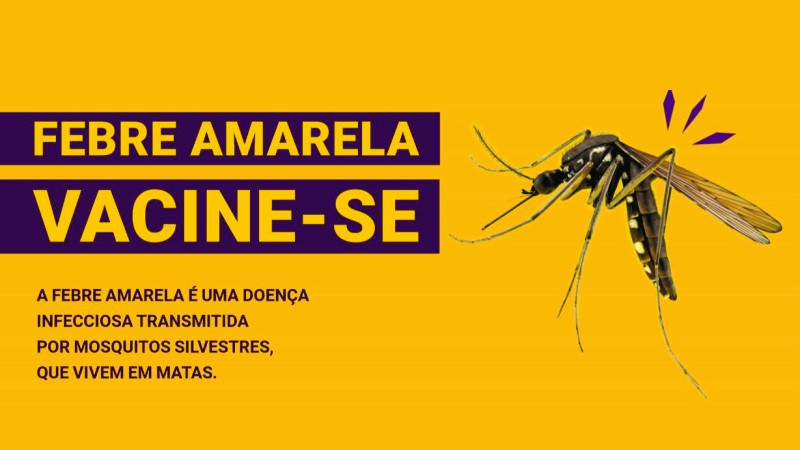

# Febre Amarela
A febre amarela é uma doença viral aguda, imunoprevenível, transmitida ao homem e a primatas não humanos (macacos), por meio da picada de mosquitos infectados. Possui dois ciclos de transmissão: silvestre (quando há transmissão em área rural ou de floresta) e urbano.

O vírus é transmitido pela picada dos mosquitos transmissores infectados e não há transmissão direta de pessoa a pessoa. Em áreas de mata, os principais vetores são os mosquitos Haemagogus e Sabethes. Já nas áreas urbanas, o vetor do vírus é o Aedes aegypti.

fonte: https://www.saude.mg.gov.br/febreamarela

# Preparando o Ambiente

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import datetime
import zipfile

In [2]:
pd.options.display.float_format = "{:.2f}".format
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
sns.set_style(style={"axes.facecolor": '#424242',
                     "figure.facecolor": '#212121',
                     "xtick.color": 'w',
                     "ytick.color": 'w',
                     "axes.edgecolor" : 'lightgrey',
                     "text.color": 'w',
                     "axes.labelcolor": 'w',
                     "axes.grid": True,
                     "grid.linestyle": "--",
                     "grid.color": 'w',
                     }
              )

In [4]:
def para_dia(ano_mes: str):
    ano: int = int(ano_mes[:4])
    mes: str = ano_mes[5:]
    mes_numero: int = meses[mes]
    return date(ano, mes_numero, 1)

In [5]:
dias_por_mes = {1 : 31, 2 : 28, 3 : 31, 4 : 30, 5 : 31, 6 : 30, 7 : 31, 8 : 31, 9 : 30, 10 : 31, 11 : 30, 12 : 31}

In [6]:
meses = {'Jan' : 1,'Fev' : 2,'Mar' : 3,'Abr' : 4,'Mai' : 5,'Jun' : 6,'Jul' : 7,'Ago' : 8,'Set' : 9,'Out' : 10,'Nov' : 11,'Dez' : 12}

In [7]:
meses_r = {v : k for k, v in meses.items()}

In [8]:
estado_sigla = {
    'Acre' : 'AC',
    'Alagoas' : 'AL',
    'Amapá' : 'AP',
    'Amazonas' : 'AM',
    'Bahia' : 'BA',
    'Ceará' : 'CE',
    'Distrito Federal' : 'DF',
    'Espírito Santo' : 'ES',
    'Goiás' : 'GO',
    'Maranhão' : 'MA',
    'Mato Grosso' : 'MT',
    'Mato Grosso do Sul' : 'MS',
    'Minas Gerais' : 'MG',
    'Pará' : 'PA',
    'Paraíba' : 'PB',
    'Paraná' : 'PR',
    'Pernambuco' : 'PE',
    'Piauí' : 'PI',
    'Rio de Janeiro' : 'RJ',
    'Rio Grande do Norte' : 'RN',
    'Rio Grande do Sul' : 'RS',
    'Rondônia' : 'RO',
    'Roraima' : 'RR',
    'Santa Catarina' : 'SC',
    'São Paulo' : 'SP',
    'Sergipe' : 'SE',
    'Tocantins' : 'TO',
}

In [9]:
sigla_estado = {v: k for k, v in estado_sigla.items()}

# Lendo os Dados de Cobertura de Vacinas

Aqui temos um conjunto de dados que informam a cobertura de vacinação por Imuno para cada Unidade da Federação.

In [10]:
archive = zipfile.ZipFile('/content/Imuno por UFs.zip', 'r')

In [11]:
def df_imuno(z_file):

  n_list = []
  for i in z_file.namelist():
    if i[0] == '_':
      pass
    else:
      n_list.append(i)
  name_list = pd.Series(n_list)
  name_list = name_list.str[22:24]
  name_list.replace(sigla_estado, inplace=True)

  df_list = []

  for n in range(len(n_list)):
    df = pd.read_csv(archive.open(n_list[n]),
                     sep=';', encoding='ISO-8859-1',
                     skiprows=4,
                     skipfooter=20,
                     engine='python'
                     )

    df = df.set_index('Imuno')

    for i in df:
      for p in range(len(df.index)):
        if df[i][p] == '...':
          df[i][p] = 0.0
        elif df[i][p] == '-':
          df[i][p] = 0.0
        else:
          df[i][p] = df[i][p].replace(',', '.')
      df[i] = df[i].astype(float)

    df = df[df.columns[:-1]]

    df_melt = df.reset_index().melt('Imuno', df.columns)
    df_melt.columns= ['IMUNO', 'ANO', 'IMUNIZADO']
    df_melt['UF'] = name_list[n]
    df_list.append(df_melt)

    df_final = pd.concat(df_list)
    df_final.reset_index(inplace=True, drop=True)
    df_final['ANO'] = df_final['ANO'].astype(int)
  return df_final

In [12]:
df_cob_fa = df_imuno(archive)
df_cob_fa

,IMUNO,ANO,IMUNIZADO,UF
0,072 BCG,1994,61.01,Acre
1,099 Hepatite B em crianças até 30 dias,1994,0.00,Acre
2,061 Rotavírus Humano,1994,0.00,Acre
3,053 Meningococo C,1994,0.00,Acre
4,073 Hepatite B,1994,11.21,Acre
...,...,...,...,...
16459,095 Tríplice Bacteriana(DTP)(1º ref),2019,47.30,Tocantins
16460,018 Sarampo,2019,0.00,Tocantins
16461,009 Haemophilus influenzae b,2019,0.00,Tocantins
16462,094 Dupla adulto e tríplice acelular gestante,2019,36.77,Tocantins


Como nosso foco é a Febre Amarela, vamos usar uma query para plotar apenas os dados que contém essa informação.

Vamos plotar o gráfico de Cobertura de imunização para cada Unidade da Federação, para tentarmos encontrar algum padrão.

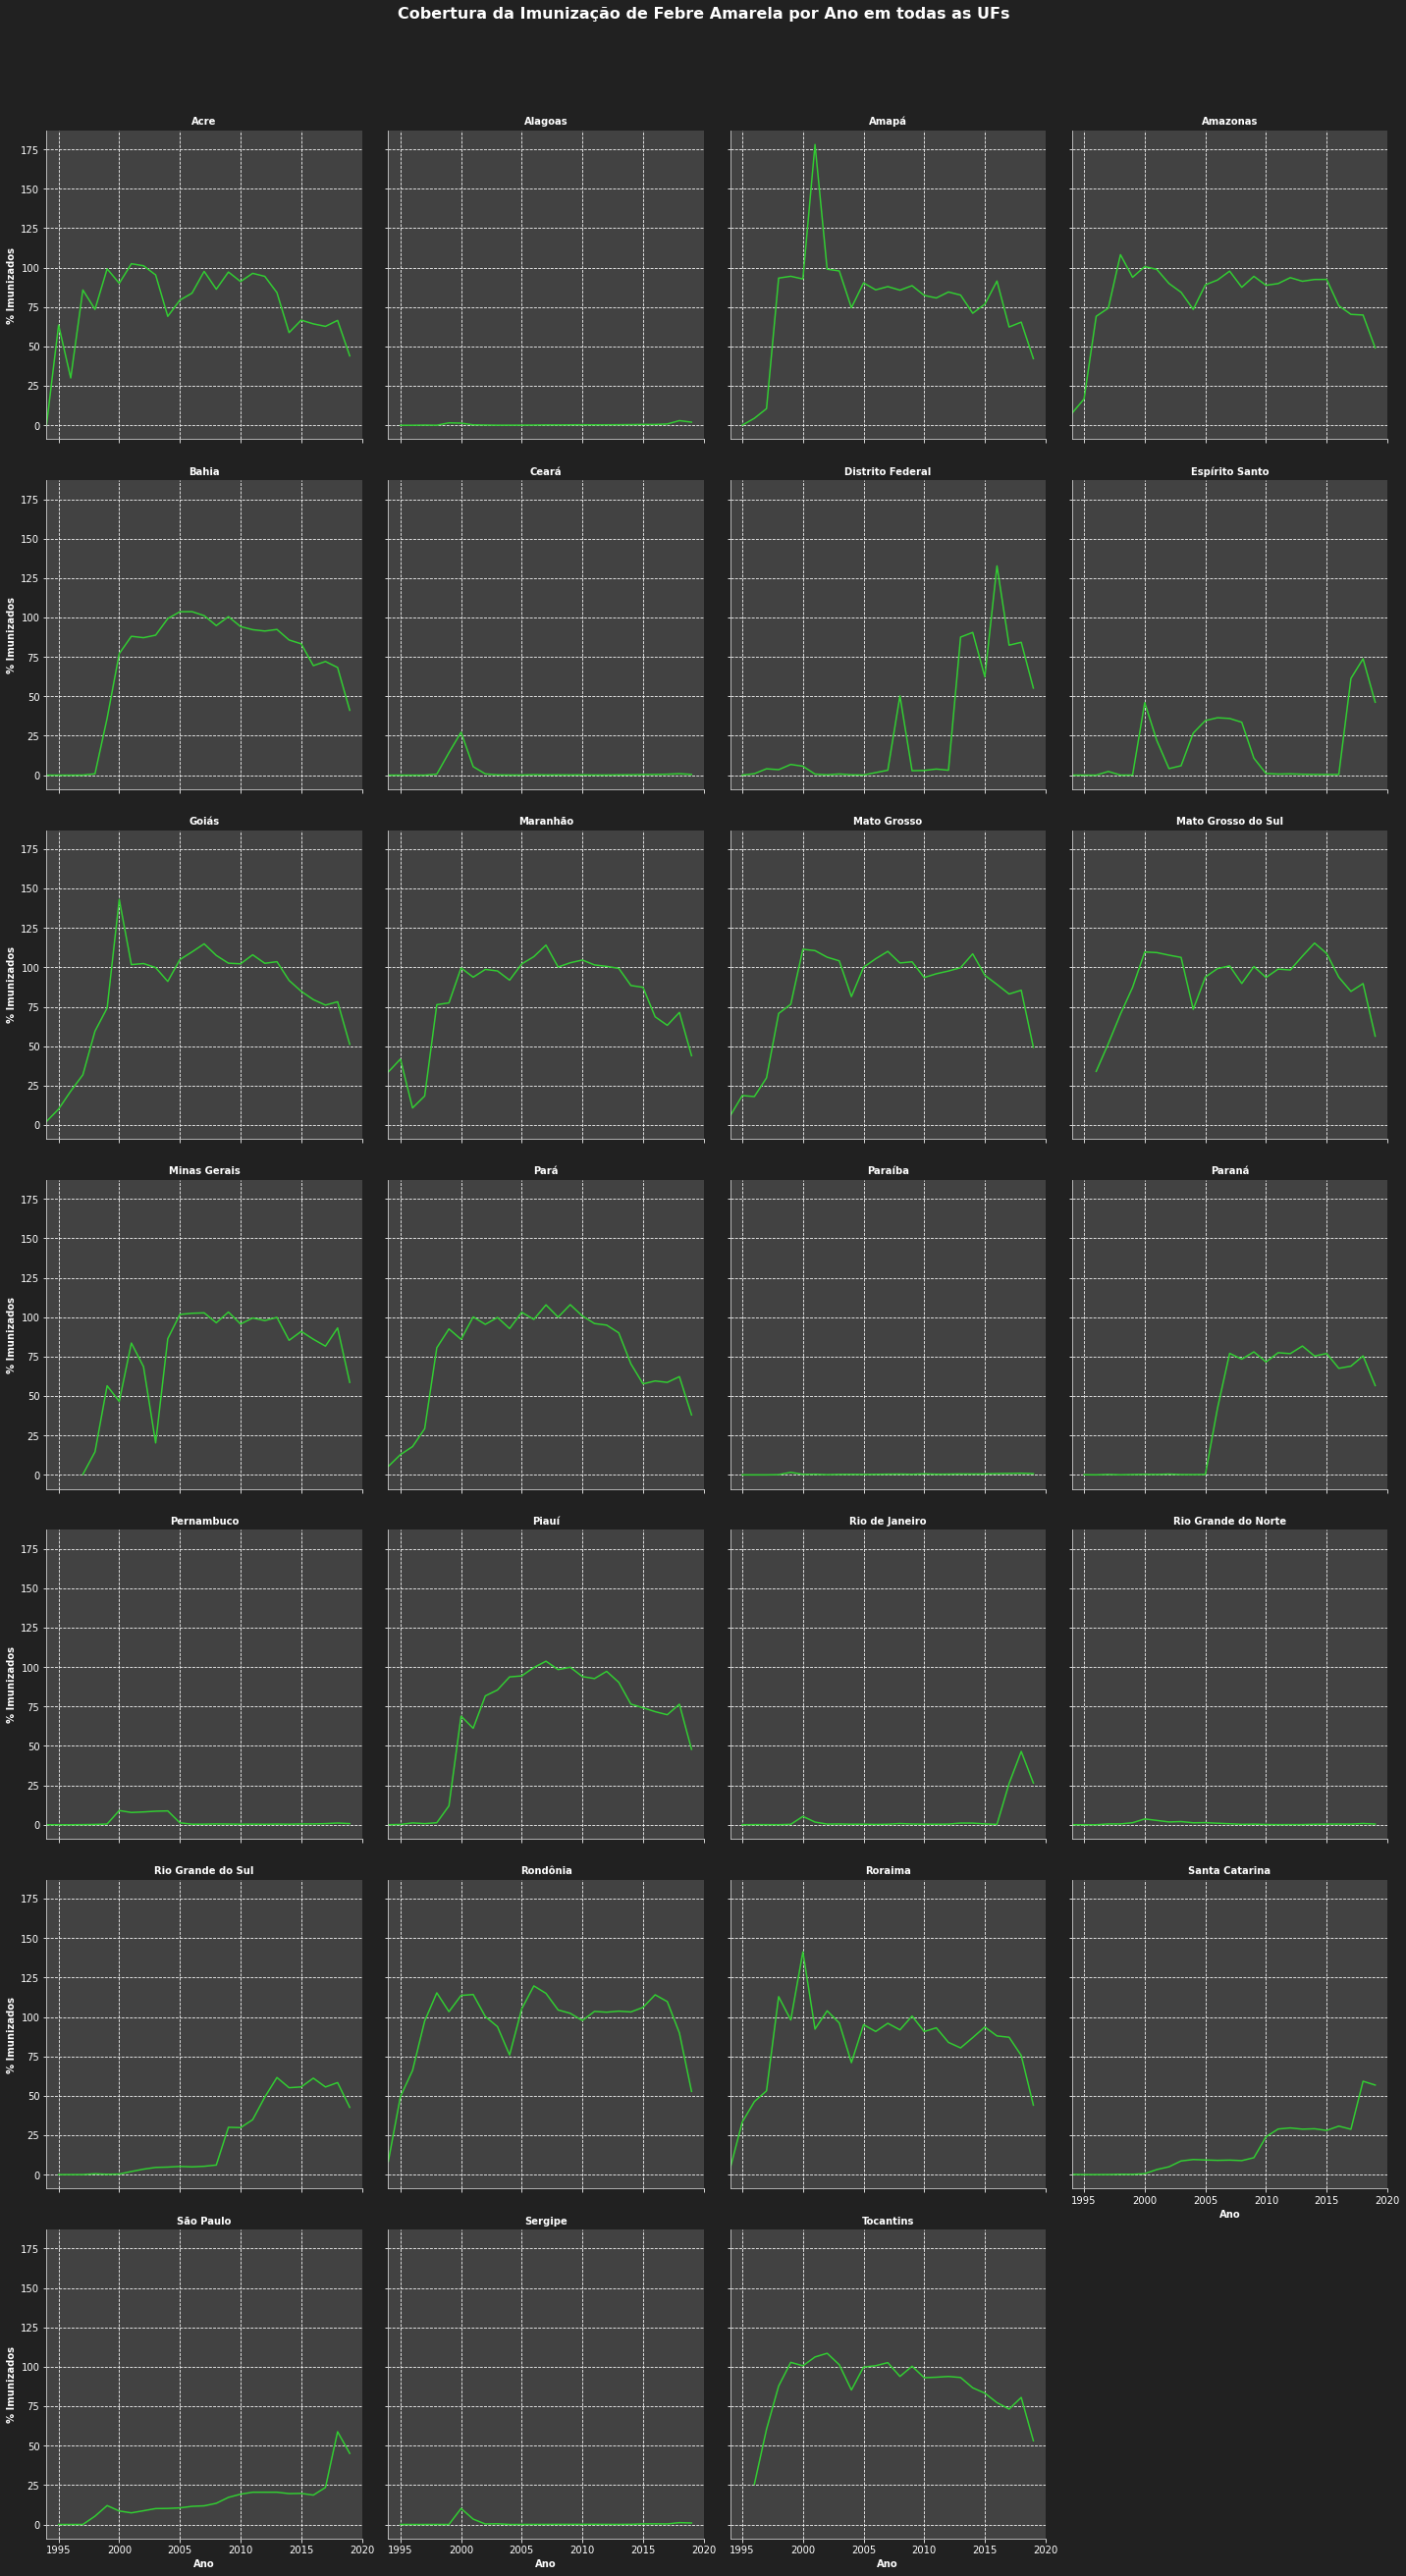

In [13]:
ax = sns.FacetGrid(data=df_cob_fa.query("IMUNO == '006 Febre Amarela'"),
                    col="UF",
                    col_wrap=4,
                    hue='UF',
                    palette=sns.color_palette(['limegreen']),
                    height=5,
                    aspect=1,
                    xlim=(1994,2020),
                    )

ax.map(sns.lineplot, 'ANO', 'IMUNIZADO')
ax.set_titles(col_template="{col_name}", fontdict={'fontsize': 13, 'fontweight': 'bold'},)
ax.set_axis_labels('Ano', '% Imunizados', fontdict={'fontsize': 10, 'fontweight': 'bold'})
ax.fig.suptitle('Cobertura da Imunização de Febre Amarela por Ano em todas as UFs', y=1.04, fontsize=16, fontweight='bold')
plt.show()

Percebemos que alguns estados não tém um histórico de imunização relevante, permanecendo perto do zero em porcentagem de imunizados.

Me chamou a atenção que o Rio de Janeiro permanecia perto de 0% de imunizados até que ocorre uma subida repentina. Isso pode indicar um surto da doença causado pela falta de vacinação.

Olhando os gráficos dos estados vizinhos, percebemos que:
* São Paulo estava abaixo de 25%, então saltou para mais de 50% no mesmo periodo da alta no Rio de Janeiro.

* O Espirito Santo teve altas em 2000 e entre 2005 e 2010. Porém, se aproximou de 0% entre 2010 e 2015, e saltou para quase75% no mesmo periodo que São Paulo e Rio de Janeiro.

* Já Minas Gerais se manteve estável próximo dos 100% a partir de 2005,com leve tendéncia de queda.

**Isso pode indicar que, os estado que não cumpriram a meta tiveram surtos, enquanto os que cumpriram não tiveram.**

Vamos analizar a ocorrência de casos nos estados da região Sudeste para testarmos esta hipótese.

# Dados Febre Amarela

In [14]:
url_fa = "https://raw.githubusercontent.com/didi-a-p/Vacinacao_Febre_Amarela/main/dados/A032522189_28_143_208%20Febre%20amarela.csv"

In [15]:
def df_fa(url):
  df = pd.read_csv(url, sep=';', encoding='ISO-8859-1', skiprows=4,skipfooter=8, engine='python')
  df = df.set_index('Unidade da Federação')
  for i in df:
    for p in range(len(df.index)):
      if df[i][p] == '...':
        df[i][p] = 0
      elif df[i][p] == '-':
        df[i][p] = 0
    df[i] = df[i].astype(int)
  df = df[df.columns[:-1]]
  df_melt = df.reset_index().melt('Unidade da Federação', df.columns)
  df_melt.columns= ['UF', 'ANO', 'CASOS_FA']
  df_melt['UF'] = df_melt['UF'].str[3:]
  df_melt['ANO'] = df_melt['ANO'].astype(int)
  return df_melt

In [16]:
dados_fa = df_fa(url_fa)

Aqui, temos uma tabela com o número de casos de Febre Amarela por Ano em cada Unidade da Federação.

In [17]:
dados_fa

,UF,ANO,CASOS_FA
0,Rondônia,2008,0
1,Acre,2008,0
2,Amazonas,2008,14
3,Roraima,2008,0
4,Pará,2008,2
...,...,...,...
373,Rio Grande do Sul,2021,0
374,Mato Grosso do Sul,2021,0
375,Mato Grosso,2021,0
376,Goiás,2021,0


Para descobrirmos se realmente houve um surto de Febre Amarela no Rio de Janeiro, vamos plotar o número de casos junto à cobertura de vacinação e ver se tivemos um aumento na mesma época.

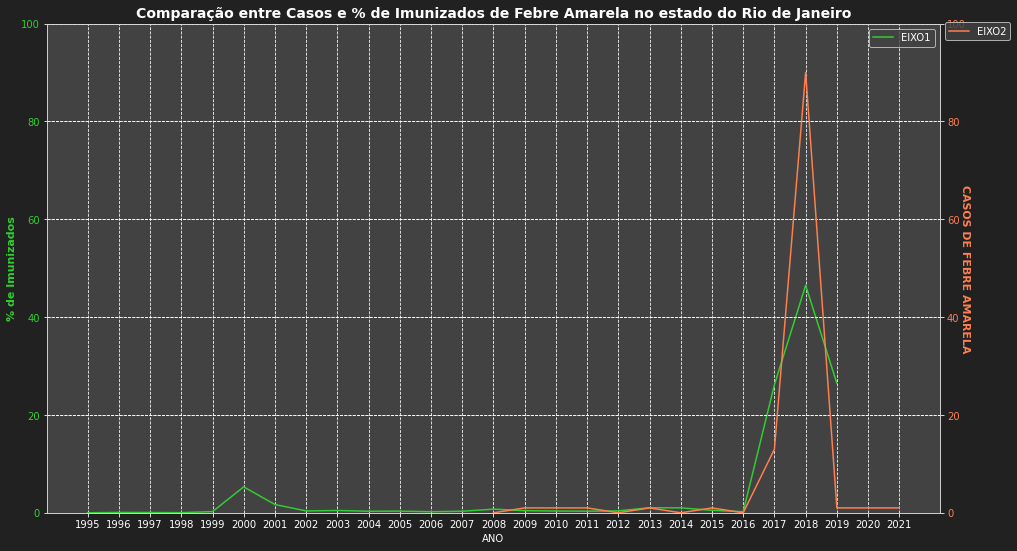

In [18]:
prim_color = 'limegreen'
sec_color = 'coral'

plt.figure(figsize=(16,9))

plt.title("Comparação entre Casos e % de Imunizados de Febre Amarela no estado do Rio de Janeiro", fontsize=14, fontweight='bold')

sns.lineplot(data=df_cob_fa.query("UF == 'Rio de Janeiro' and IMUNO == '006 Febre Amarela'"), x='ANO', y='IMUNIZADO', color='limegreen', label = 'EIXO1')
plt.ylim(0,100)
plt.ylabel("% de Imunizados", rotation=90, color=prim_color, fontsize=11, fontweight='bold')
plt.yticks(color=prim_color)

ax2 = plt.twinx()
sns.lineplot(data=dados_fa.query("UF == 'Rio de Janeiro'"),x='ANO', y='CASOS_FA', color=sec_color, ax=ax2, label='EIXO2')
plt.legend(bbox_to_anchor=(1, 1.013), loc='upper left', )

plt.ylim(0,100)
plt.ylabel("CASOS DE FEBRE AMARELA", rotation=270, color=sec_color, fontsize=11, fontweight='bold')
plt.yticks(color=sec_color)

plt.xticks(list(range(1995,2022)))
plt.show()

Ao analizarmos o gráfico, percebemos que houve sim um aumento do número de casos, mas não foi tão significante.

Vamos plotar um gráfico para cada estado da região Sudeste para compararmos a cobertura de vacinas com o número de casos de Febre Amarela em cada caso.

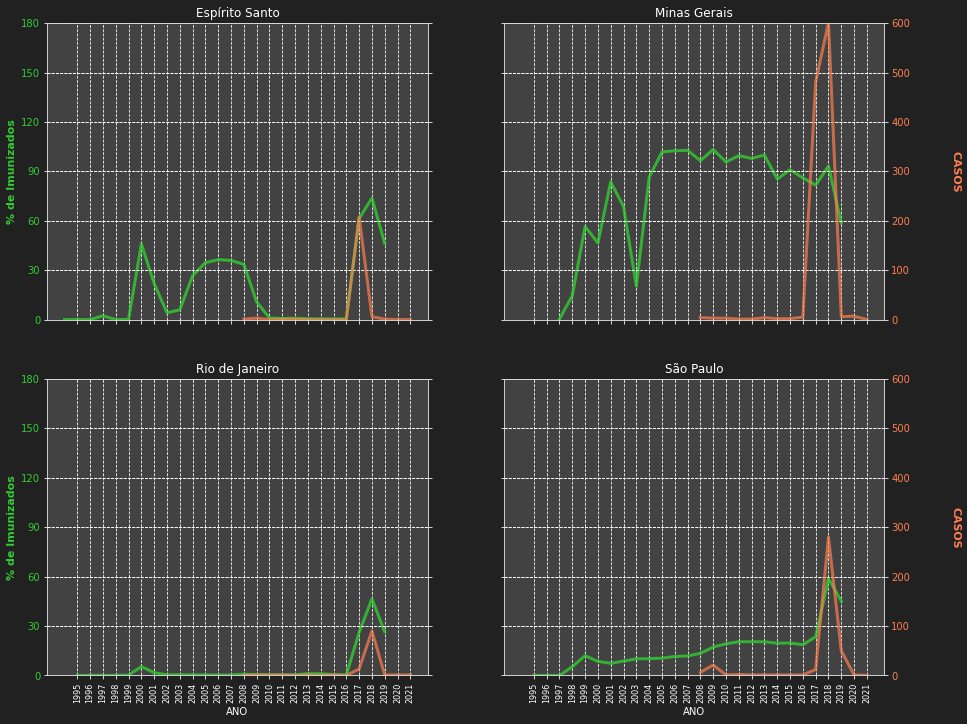

In [40]:
ufs = [sigla_estado[i] for i in ['MG','ES','RJ','SP']]
ufs.sort()

n_row=list(range(2))*2
n_row.sort()
n_col=list(range(2))*2

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,12), squeeze=True)
for n in range(len(n_row)):
  estado_n = ufs[n]
  l1 =sns.lineplot(x='ANO',
                  y='IMUNIZADO',
                  ax=axs[n_row[n], n_col[n]],
                  data=df_cob_fa.query("UF == @estado_n and IMUNO == '006 Febre Amarela'"),
                  color='limegreen',
                  label = '% Imunizados',
                  legend=False,
                  linewidth=3, 
                  alpha=0.8
                  )
  l1.set_ylabel("% de Imunizados", rotation=90, color=prim_color, fontsize=11, fontweight='bold')
  l1.set_ylim(0,180)
  l1.set_yticks(list(range(0, 200, 30)))
  l1.set_yticklabels(list(range(0, 200, 30)),color=prim_color)
  l1.set_xticklabels(list(range(1995,2022)), rotation=90, fontsize=8)
  l1.set_xticks(list(range(1995,2022)))

  ax2 = plt.twinx(ax=axs[n_row[n], n_col[n]])
  l2 = sns.lineplot(data=dados_fa.query("UF == @estado_n"),
                    x='ANO',
                    y='CASOS_FA',
                    color=sec_color,
                    ax=ax2,
                    label='EIXO2',
                    legend=False,
                    linewidth=3, 
                    alpha=0.7
                  )
  if n_col[n] != 0:
    l2.set_ylabel("CASOS", rotation=270, color=sec_color, fontsize=11, fontweight='bold')
    l2.set_ylim(0,600)
    l2.set_yticks(list(range(0,650,100)))
    l2.set_yticklabels(list(range(0,650,100)),color=sec_color)
    l2.yaxis.set_label_coords(1.2,0.5)
  else:
    l2.set_ylim(0,600)
    l2.set_yticks(list(range(0,650,100)))
    l2.set_yticklabels(list(range(0,650,100)),color=sec_color)
    l2.yaxis.set_tick_params(labelright=False)
    l2.yaxis.set_label_text('')

  axs[n_row[n], n_col[n]].set_title(ufs[n])



Analizando o gráfico, reparamos que ocorreu um surto entre 2017 e 1019.

Mas o verdadeiro surto, ao contrário do que pensamos, ocorreu em Minas Gerais, que mantinha sua cobertura de vacinação próximo dos 100%

Vamos importar as bases de **Doses Aplicadas por Mês** e **Internações por Mês** de Febre Amarela em cada Unidade da Federação, para termos uma visão mais detalhada do surto.

## Doses aplicadas Febre Amarela

In [20]:
url_doses_aplicadas = "https://raw.githubusercontent.com/didi-a-p/Vacinacao_Febre_Amarela/main/dados/dpnibr16235389350%20DOSES%20APLICADAS%20%20Febre%20Amarela%20(FA).csv"

In [21]:
df_doses = pd.read_csv(url_doses_aplicadas, sep=';', encoding='ISO-8859-1')

,Unidade da Federação,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004/Jan,2004/Fev,2004/Mar,2004/Abr,2004/Mai,2004/Jun,2004/Jul,2004/Ago,2004/Set,2004/Out,2004/Nov,2004/Dez,2005/Jan,2005/Fev,2005/Mar,2005/Abr,2005/Mai,2005/Jun,2005/Jul,2005/Ago,2005/Set,2005/Out,2005/Nov,2005/Dez,2006/Jan,2006/Fev,2006/Mar,2006/Abr,2006/Mai,...,2018/Mai,2018/Jun,2018/Jul,2018/Ago,2018/Set,2018/Out,2018/Nov,2018/Dez,2019/Jan,2019/Fev,2019/Mar,2019/Abr,2019/Mai,2019/Jun,2019/Jul,2019/Ago,2019/Set,2019/Out,2019/Nov,2019/Dez,2020/Jan,2020/Fev,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Dez,Total
0,11 Rondônia,145068,226411,203138,166436,290311,161955,211016,186696,104735,115022,3599,3371,4131,12741,10933,7864,7194,9286,7780,5939,5445,4021,5577,6006,6802,9562,19935,14013,11476,15659,9497,6439,6499,4968,6895,5523,7354,9253,16215,...,5271,5578,6697,8202,5181,4916,3965,3261,4769,4624,4438,5060,5392,4768,5103,3912,3546,5579,5415,3895,5478,10089,8805,3852,7765,7304,7247,6797,6162,13398,9439,4695,4131,4707,5160,5788,6467,1228,0,3814483
1,12 Acre,0,69684,38659,107705,92187,271986,64157,53164,43132,48338,2489,2255,2262,3859,3009,3914,2441,3154,3616,2827,3064,2985,2504,2846,4443,4635,7013,4473,3522,6406,4912,2657,3464,3997,4159,3461,3619,4214,5487,...,1799,1602,2060,2054,1525,1692,1532,1308,2093,2082,1874,1914,1986,1748,2033,1855,1511,1687,2093,1895,3438,3607,3225,1129,1711,1636,2049,2023,2540,4796,3056,2046,2137,1670,2088,3351,2351,73,0,1676557
2,13 Amazonas,208007,150657,825292,421308,549112,333421,415695,336329,252583,237617,12188,11002,10106,24769,16566,16050,14510,17584,16021,10625,19360,14657,12358,13069,17821,19642,29793,25579,23332,21232,18567,19080,16846,15887,18916,16601,22766,23711,33295,...,14545,12857,22133,23220,16273,15852,11753,9678,14885,14217,16975,14922,14715,13376,12746,15200,13710,12632,12016,9111,33971,23717,22886,2844,14750,21826,18799,20447,17694,36415,20257,13022,8946,11572,15695,16477,18057,2448,0,8388663
3,14 Roraima,10273,48298,47661,33080,162470,43500,62296,47140,41361,61590,3717,7975,3180,3449,3835,3298,4360,3473,4941,3731,4242,1405,5202,12615,8960,4984,4895,7622,6065,9558,5058,6691,4938,4684,6690,5234,5718,4054,5434,...,4476,3366,4195,3621,3171,10496,10584,10844,12471,8810,7599,7184,6952,3019,3766,6888,6446,10558,6440,7248,8127,7070,5251,834,1260,1636,3362,2010,2254,3990,2214,2142,3559,3038,3076,3309,1408,300,0,1498647
4,15 Pará,88991,84984,194235,710311,2911623,1495557,1011092,599046,419592,596873,24115,26692,20410,39693,32671,76498,36174,53084,33095,24100,36459,21278,19287,24528,31221,43167,62801,47815,25244,66589,31093,27721,26738,23899,25880,26843,26339,32011,35563,...,16815,14527,17804,20365,16733,16428,14237,10253,18276,18095,16634,16787,17784,16816,18015,17929,14513,16512,17187,11453,22671,26915,28736,9192,12290,20284,28866,25252,24398,38107,27100,16036,19724,18146,21401,20674,17579,2561,0,14796948


In [22]:
df_doses['Unidade da Federação'] = df_doses['Unidade da Federação'].str[3:]

In [23]:
df_doses.set_index('Unidade da Federação', inplace=True)

In [24]:
df_doses = df_doses[df_doses.columns[10:-1]]

In [25]:
df_doses.columns = df_doses.columns.map(para_dia)

In [26]:
df_doses_melt = df_doses.reset_index().melt(id_vars='Unidade da Federação')
df_doses_melt.columns= ['UF', 'ANO_MES', 'DOSES']

Aqui temos a tabela de Doses de Vacina contra a Febre Amarela aplicadas por Mês em cada Unidade da Federação.

In [27]:
df_doses_melt

,UF,ANO_MES,DOSES
0,Rondônia,2004-01-01,3599
1,Acre,2004-01-01,2489
2,Amazonas,2004-01-01,12188
3,Roraima,2004-01-01,3717
4,Pará,2004-01-01,24115
...,...,...,...
5903,Mato Grosso do Sul,2021-12-01,0
5904,Mato Grosso,2021-12-01,0
5905,Goiás,2021-12-01,0
5906,Distrito Federal,2021-12-01,0


## Internacoes Febre amarela

In [28]:
url_int_fa = "https://raw.githubusercontent.com/didi-a-p/Vacinacao_Febre_Amarela/main/dados/A223338189_28_143_208%20Internacoes%20Febre%20amarela%20ANO-MES.csv"

In [29]:
def df_int_fa_(url):
  df = pd.read_csv(url, sep=';', encoding='ISO-8859-1', skiprows=4,skipfooter=8, engine='python')
  df = df.set_index('Unidade da Federação')
  for i in df:
    for p in range(len(df.index)):
      if df[i][p] == '...':
        df[i][p] = 0
      elif df[i][p] == '-':
        df[i][p] = 0
    df[i] = df[i].astype(int)
  df = df[df.columns[:-1]]
  df.columns = df.columns.map(para_dia)
  df_melt = df.reset_index().melt('Unidade da Federação', df.columns)
  df_melt.columns= ['UF', 'ANO_MES', 'INTERNACOES_FA']
  df_melt['UF'] = df_melt['UF'].str[3:]
  df_melt['INTERNACOES_FA'] = df_melt['INTERNACOES_FA'].astype(int)
  return df_melt

Aqui temos a tabela de Internações de Febre Amarela por Mês em cada Unidade da Federação.

In [30]:
 df_int_fa = df_int_fa_(url_int_fa)
 df_int_fa

,UF,ANO_MES,INTERNACOES_FA
0,Rondônia,2007-11-01,0
1,Acre,2007-11-01,0
2,Amazonas,2007-11-01,0
3,Roraima,2007-11-01,0
4,Pará,2007-11-01,0
...,...,...,...
3586,Rio Grande do Sul,2021-04-01,0
3587,Mato Grosso do Sul,2021-04-01,0
3588,Mato Grosso,2021-04-01,0
3589,Goiás,2021-04-01,0


Aqui vamos unir as tabelas de Doses aplicadas com a tabela de Internações.

In [31]:
df_doses_int_fa = pd.merge(df_doses_melt, df_int_fa, on=['UF', 'ANO_MES'])
df_doses_int_fa

,UF,ANO_MES,DOSES,INTERNACOES_FA
0,Rondônia,2007-11-01,7598,0
1,Acre,2007-11-01,7454,0
2,Amazonas,2007-11-01,21968,0
3,Roraima,2007-11-01,5052,0
4,Pará,2007-11-01,33277,0
...,...,...,...,...
3586,Rio Grande do Sul,2021-04-01,29797,0
3587,Mato Grosso do Sul,2021-04-01,10281,0
3588,Mato Grosso,2021-04-01,12045,0
3589,Goiás,2021-04-01,25451,0


Em seguida, vamos plotar os gráficos para cada estado da região Sudeste e vamos analizar como se desenvolveu o surto de Febre Amarela na região.

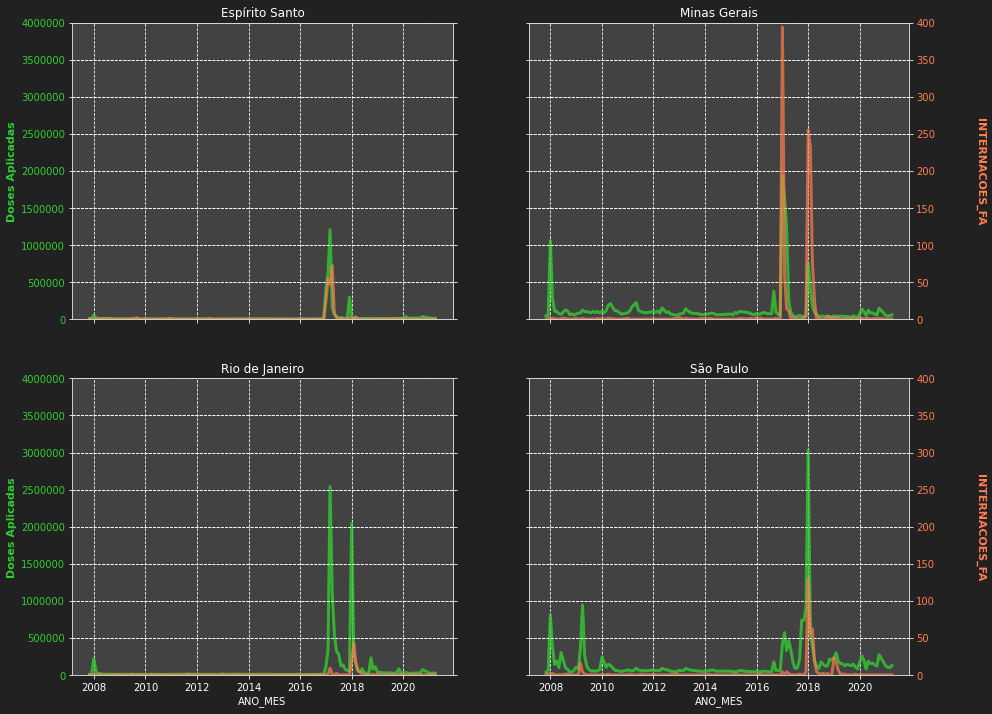

In [42]:
ufs = [sigla_estado[i] for i in ['MG','ES','RJ','SP']]
ufs.sort()

n_row=list(range(2))*2
n_row.sort()
n_col=list(range(2))*2

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,12), squeeze=True)
for n in range(len(n_row)):
  estado_n = ufs[n]
  l1 =sns.lineplot(x='ANO_MES',
                  y='DOSES',
                  ax=axs[n_row[n], n_col[n]],
                  data=df_doses_int_fa.query("UF == @estado_n"), alpha=0.8,
                  color='limegreen',
                  label = '% Imunizados',
                  legend=False,
                  linewidth=3
                  )
  l1.set_ylabel("Doses Aplicadas", rotation=90, color=prim_color, fontsize=11, fontweight='bold')
  l1.set_ylim(0,4000000)
  l1.set_yticks(list(range(0, 4500000, 500000)))
  l1.set_yticklabels(list(range(0, 4500000, 500000)),color=prim_color)

  ax2 = plt.twinx(ax=axs[n_row[n], n_col[n]])
  l2 = sns.lineplot(data=df_doses_int_fa.query("UF == @estado_n"), alpha=0.7,
                    x='ANO_MES',
                    y='INTERNACOES_FA',
                    color=sec_color,
                    ax=ax2,
                    label='EIXO2',
                    legend=False,
                    linewidth=3
                  )
  if n_col[n] != 0:
    l2.set_ylabel("INTERNACOES_FA", rotation=270, color=sec_color, fontsize=11, fontweight='bold', )
    l2.set_ylim(0,400)
    l2.set_yticks(list(range(0,450,50)))
    l2.set_yticklabels(list(range(0,450,50)),color=sec_color)
    l2.yaxis.set_label_coords(1.2,0.5)
  else:
    l2.set_ylim(0,400)
    l2.set_yticks(list(range(0,450,50)))
    l2.set_yticklabels(list(range(0,450,50)),color=sec_color)
    l2.yaxis.set_tick_params(labelright=False)
    l2.yaxis.set_label_text('')

  axs[n_row[n], n_col[n]].set_title(ufs[n])

Pelo gráfico, percebemos que:
* O surto em Minas Gerais foi repentino.

* Os oitros estados da região tiveram um aumento no número de casos, mas não se comparam com o estado de Minas Gerais.

* Reagindo à gravidade do surto no estado de Minas e au aumento de casos neles próprios, os outros estado tiveram um aumento considerável nas doses aplicadas de vacinas contra a Febre Amarela.
* Parece ter uma relação entre a quantidade de Doses aplicadas com o número de Internações de Febre Amarela.

Vamos fazer um gráfico de dispersão para analizarmos essa correlação.

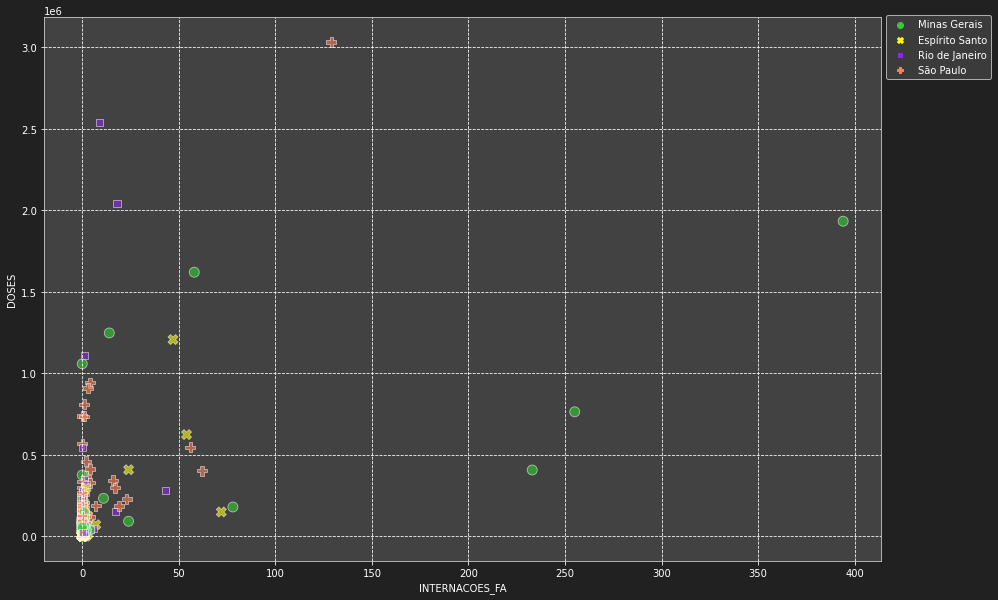

In [48]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df_doses_int_fa.query("UF in @ufs"),
                x='INTERNACOES_FA',
                y='DOSES',
                hue='UF',
                palette=sns.color_palette(['limegreen','yellow','blueviolet','coral']),
                style='UF', s=100, alpha=0.6
                )
plt.legend(bbox_to_anchor=(1, 1.013), loc='upper left')

Esse gráfico nos mostra que:
* O Rio de Janeiro conseguiu manter o número de internações abaixo de 50 por mês durante o surto, ao mesmo tempo que teve dois dos três maiores valores de doses aplicadas por mês.
* Minas Gerais não consiguiu ultrapassar 2.000.000 de Doses em um mês, mesmo quando a os internados se apriximavam de 400.

Agora vamos relacionar as Doses Aplicadas com as Internações e plotar essa relação em função do tempo.

In [34]:
df_doses_int_fa['DOSE_INT'] = df_doses_int_fa.DOSES / df_doses_int_fa.INTERNACOES_FA

In [35]:
df_doses_int_fa

,UF,ANO_MES,DOSES,INTERNACOES_FA,DOSE_INT
0,Rondônia,2007-11-01,7598,0,inf
1,Acre,2007-11-01,7454,0,inf
2,Amazonas,2007-11-01,21968,0,inf
3,Roraima,2007-11-01,5052,0,inf
4,Pará,2007-11-01,33277,0,inf
...,...,...,...,...,...
3586,Rio Grande do Sul,2021-04-01,29797,0,inf
3587,Mato Grosso do Sul,2021-04-01,10281,0,inf
3588,Mato Grosso,2021-04-01,12045,0,inf
3589,Goiás,2021-04-01,25451,0,inf


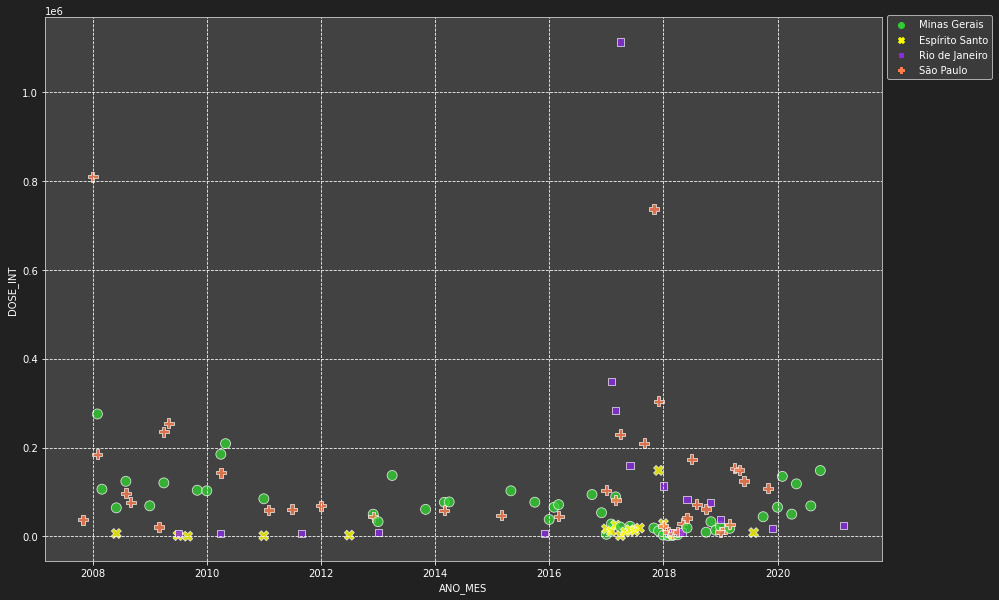

In [49]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=df_doses_int_fa.query("UF in @ufs"),
                     x='ANO_MES',
                     y='DOSE_INT',
                     hue='UF',
                     palette=sns.color_palette(['limegreen','yellow','blueviolet','coral']),
                     style='UF',
                     s=100,
                     alpha=0.8
                     )
plt.legend(bbox_to_anchor=(1, 1.013), loc='upper left')

## Conclusão:

Com esse gráfico, percebemos que o Rio de Janeiro teve uma resposta melhor em relação ao numero de Doses de vacina aplicadas por cada caso de Internação causada por Febre amarela.

Essa pode ter sido uma das razões do surto não ter sido tão grave como nos outros estados.

Já em Minas Gerais, a razão de Doses Aplicadas por cado de Internação foi muito baixa durante o surto, o que pode justificar a sua gravidade.

Segestão para analises futuras:
* Influencia da vacina para Febre Amarela nos gastos do sus.
* Influencia da vacina para Febre Amarela no número de óbitos.